# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [3]:
b = emcee.backends.HDFBackend('emulators/backends/eps_1.0000e-02_ntrain_700_fat_0.3_no_gp_var.h5')

with open('emulators/emu_eps_1.0000e-02_ntrain_700_fat_0.3.pkl', 'rb') as f:
    emu = pickle.load(f)

In [4]:
emu._info['pc'].shape

(700, 106)

In [5]:
chain = b.get_chain()

In [6]:
lnp = b.get_log_prob()

In [7]:
lnp[0]

array([ -1668.65854704,   -778.87561603,  -1525.52123654,  -1148.62609512,
        -1433.21983393,   -957.49196895,   -769.58598797,  -2129.28917793,
         -679.21318978,   -772.2430369 ,   -897.1431355 ,  -1087.47827546,
        -1325.2691016 ,   -871.94855701,  -1993.59647529,  -1193.19140016,
        -1311.47300965,   -951.59029033,  -1846.88122318, -13288.42569602,
        -1023.3619943 ,   -969.44466957,  -1605.81548323, -10741.58122244,
        -2018.09108441,   -667.73011003,  -1838.28712565,  -2189.82789525,
         -955.23916957,  -1989.06438912,  -1035.87360885,  -1662.84219877,
        -1264.23518707,   -869.35670114,  -3015.42211709,   -945.54277626,
        -1227.87978069,   -950.12802808,  -1419.54619345,  -1214.56622272,
        -2153.12678421,   -859.11174984,  -2119.53595715,  -1149.7878091 ,
        -1697.02425474,  -1250.71062946,  -2613.51258776,   -948.63700869,
        -1336.05090095,  -2867.20593071,   -829.47766068,  -1040.29559671,
        -1117.80323032,  

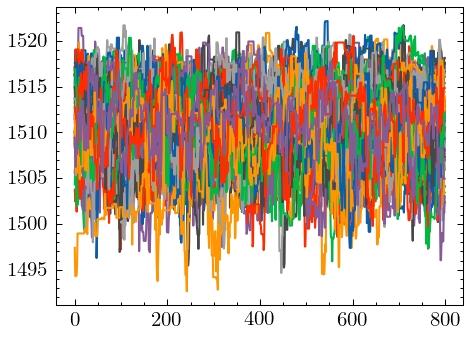

In [10]:
nb = 200
cutoff = 1491

ii = np.where(np.min(lnp[nb:, :], axis=0) > cutoff)[0]

plt.plot(lnp[nb:, ii]);

In [11]:
design_chain = np.load('datfiles/fat_0.3_posterior_chain.npy')

def plot_chain_summary(ch, ax):
    low, med, high = np.quantile(ch, [0.16, 0.5, 0.84])
    ax.axhspan(low, high, color='C1', alpha=0.5)
    ax.axhline(med, color='C1')

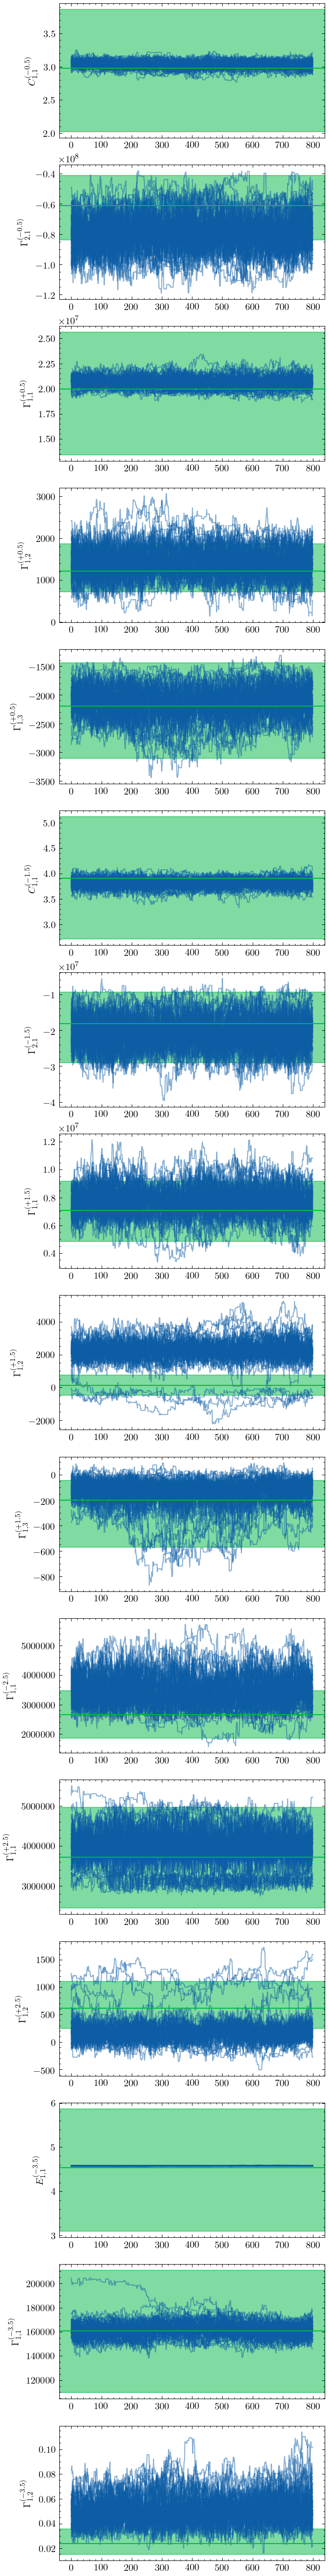

In [12]:
fig, ax = plt.subplots(model.nrpar, figsize=(gr*h, model.nrpar*h))
fig.patch.set_facecolor('white')

for i in range(model.nrpar):
    ax[i].plot(chain[nb:, ii, i], alpha=0.5, color='C0')
    ax[i].set_ylabel(model.azr.config.labels[i])
    plot_chain_summary(design_chain[:, i], ax[i])

In [13]:
# fig, ax = plt.subplots(model.nf_capture, 
#                        figsize=(gr*h, model.nf_capture*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar, model.nrpar + model.nf_capture)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [14]:
# fig, ax = plt.subplots(model.nf_scatter, 
#                        figsize=(gr*h, model.nf_scatter*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar + model.nf_capture, model.ndim)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [15]:
n1 = model.nbr
n2 = model.nxs

In [16]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [17]:
lnp[np.argmin(lnp)]

-13288.425696020528

In [18]:
lnp.shape

(64000,)

In [19]:
theta_bad = flat_chain[np.argmin(lnp), :]

In [20]:
np.argmin(lnp)

19

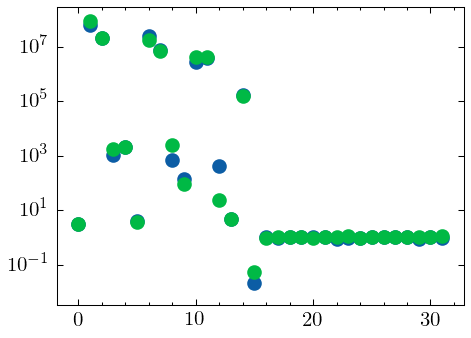

In [21]:
plt.scatter(np.arange(theta_bad.size), np.abs(theta_bad))
plt.scatter(np.arange(theta_star.size), np.abs(theta_star))
plt.yscale('log');

In [22]:
from bayes import ln_prior, Model

In [23]:
m = Model(emu)

In [24]:
m.ln_likelihood(theta_bad)

-334.6089028961294

In [25]:
m.ln_likelihood(theta_star)

1324.8681143849112

In [26]:
print(f'{m.ln_likelihood(theta_bad, include_gp_var=False):.4e}')
print(f'{m.ln_likelihood(theta_star, include_gp_var=False):.4e}')

-1.3109e+04
1.7019e+03


In [27]:
from multiprocessing import Pool

In [28]:
# with Pool(processes=16) as pool:
#     lnpi = pool.map(ln_prior, flat_chain)

In [29]:
# lnpi = np.array(lnpi)

In [30]:
# plt.hist(lnp[500:] - lnpi[500:],bins=200, density=True)
# # plt.xlim([-1000, 750])
# plt.xlabel('$\ln\mathcal{L}$')
# plt.ylabel('Density');

In [31]:
mu_star = model.calculate(theta_star)
mu_bad = model.calculate(theta_bad)

In [32]:
def plot_prediction(theta, ax, start, stop, color='C2', label=None, x=model.x):
    p = emu.predict(theta=theta[:16])
    mu = p.mean().flatten()
    var = p.var().flatten()
    ax.errorbar(x[start:stop], mu[start:stop], yerr=np.sqrt(var[start:stop]),
                linestyle='', capsize=2, color=color, marker='x', alpha=0.5, label=label)

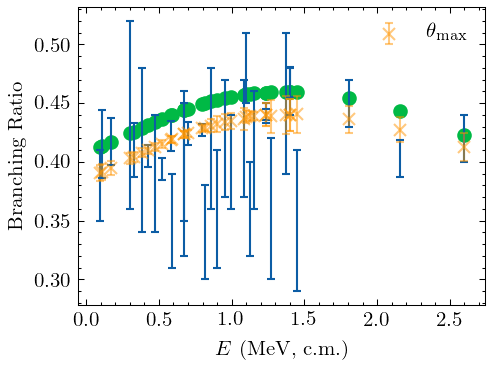

In [33]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[:n1], model.y[:n1], yerr=model.dy[:n1], linestyle='', capsize=2)
ax.scatter(model.x[:n1], mu_star[:n1], color='C1')
# ax.scatter(model.x[:n1], mu_bad[:n1], color='C4')

plot_prediction(theta_star, ax, 0, n1, label=r'$\theta_{\max}$')
# plot_prediction(theta_bad, ax, 0, n1, color='C3', label=r'$\theta_{\min}$')
# ax.errorbar(model.x[:n1], mu_star_gp[:n1], yerr=np.sqrt(mu_star_gp_var[:n1]), linestyle='', capsize=2, color='C2')

ax.legend()
ax.set_ylabel('Branching Ratio')
ax.set_xlabel('$E$ (MeV, c.m.)');

Text(0.5, 0, '$E$ (MeV, c.m.)')

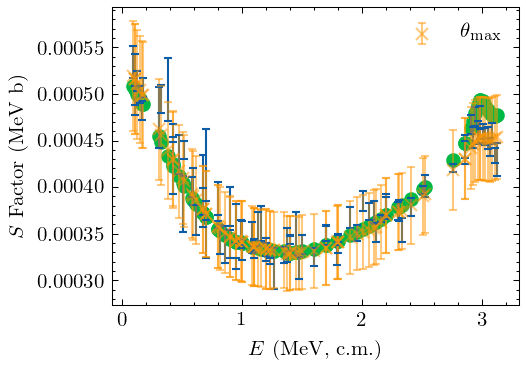

In [34]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], model.y[n1:n1+n2], yerr=model.dy[n1:n1+n2], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1, n1+n2, label=r'$\theta_{\max}$', color='C2')
# plot_prediction(theta_bad, ax, n1, n1+n2, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.x[n1:n1+n2], mu_star[n1:n1+n2], color='C1')
# ax.scatter(model.x[n1:n1+n2], mu_bad[n1:n1+n2], color='C4')

# ax.scatter(model.x[n1:n1+n2], 1000*mu_star[n1:n1+n2], color='C1')
# ax.errorbar(model.x[n1:n1+n2], 1000*mu_star_gp[n1:n1+n2], yerr=1000*np.sqrt(mu_star_gp_var[n1:n1+n2]), linestyle='',
#             capsize=2, color='C2')

ax.legend()
ax.set_ylabel('$S$ Factor (MeV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
# ax.set_xscale('log');

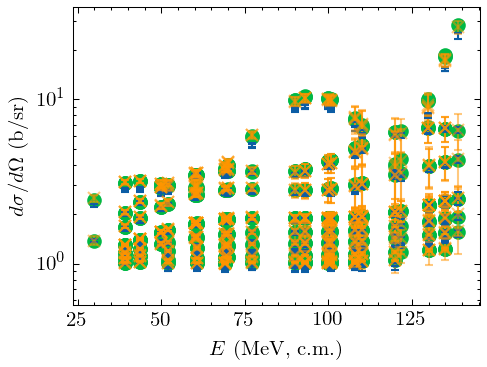

In [35]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.angles[n1+n2:], model.y[n1+n2:], yerr=model.dy[n1+n2:], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1+n2, None, label=r'$\theta_{\max}$', x=model.angles)
# plot_prediction(theta_bad, ax, n1+n2, None, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.angles[n1+n2:], mu_star[n1+n2:], color='C1')
# ax.errorbar(model.x[n1+n2:], mu_star_gp[n1+n2:], yerr=np.sqrt(mu_star_gp_var[n1+n2:]), linestyle='',
#             capsize=2, color='C2')

ax.set_ylabel(r'$d\sigma/d\Omega$ (b/sr)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_yscale('log');

In [36]:
from run import Run

In [37]:
import pickle

with open('/spare/odell/7Be/CP/samples/model_1_2021-08-06-02-55-37.pkl', 'rb') as f:
    run = pickle.load(f)

In [38]:
cs_flat_chain = run.get_flat_chain()

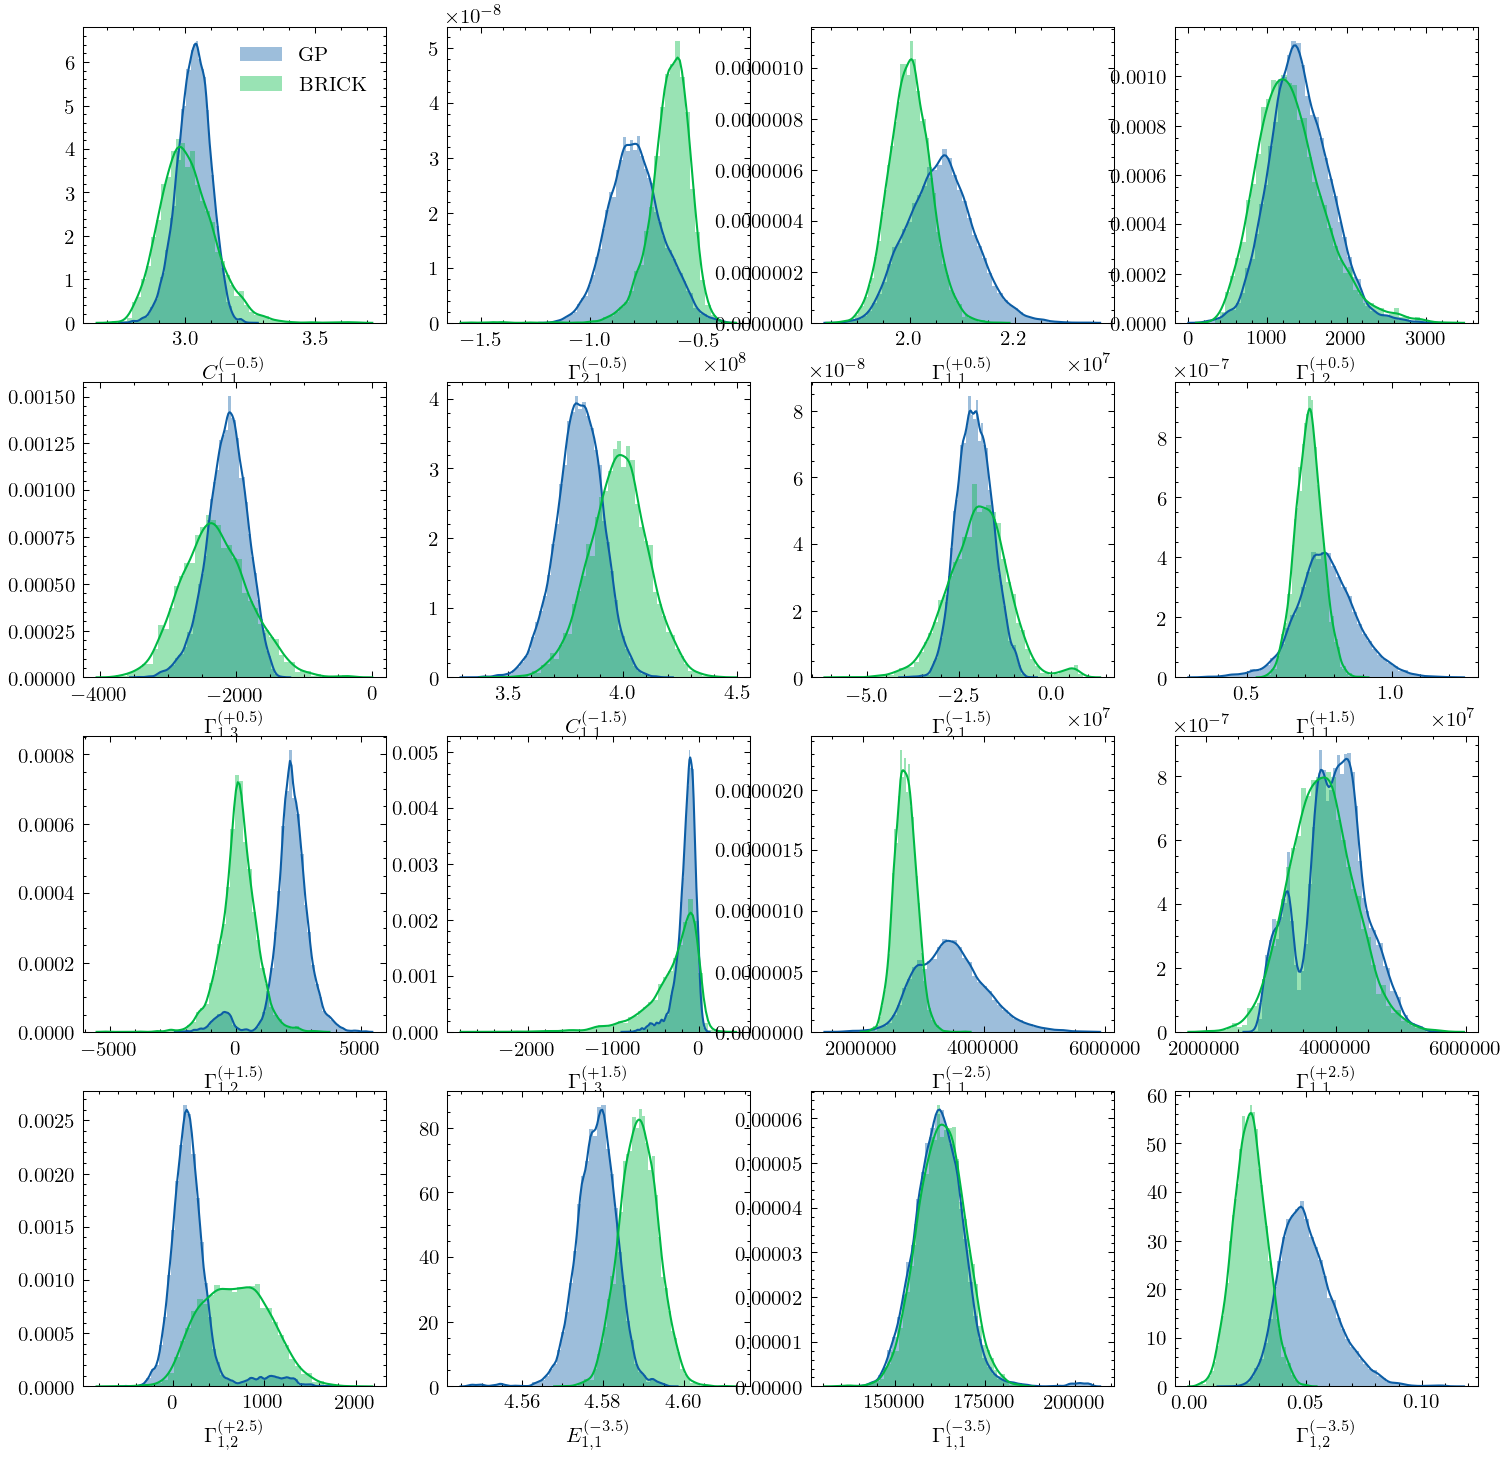

In [39]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = i*4 + j
        sns.distplot(chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel(model.azr.config.labels[k])
ax[0, 0].legend();

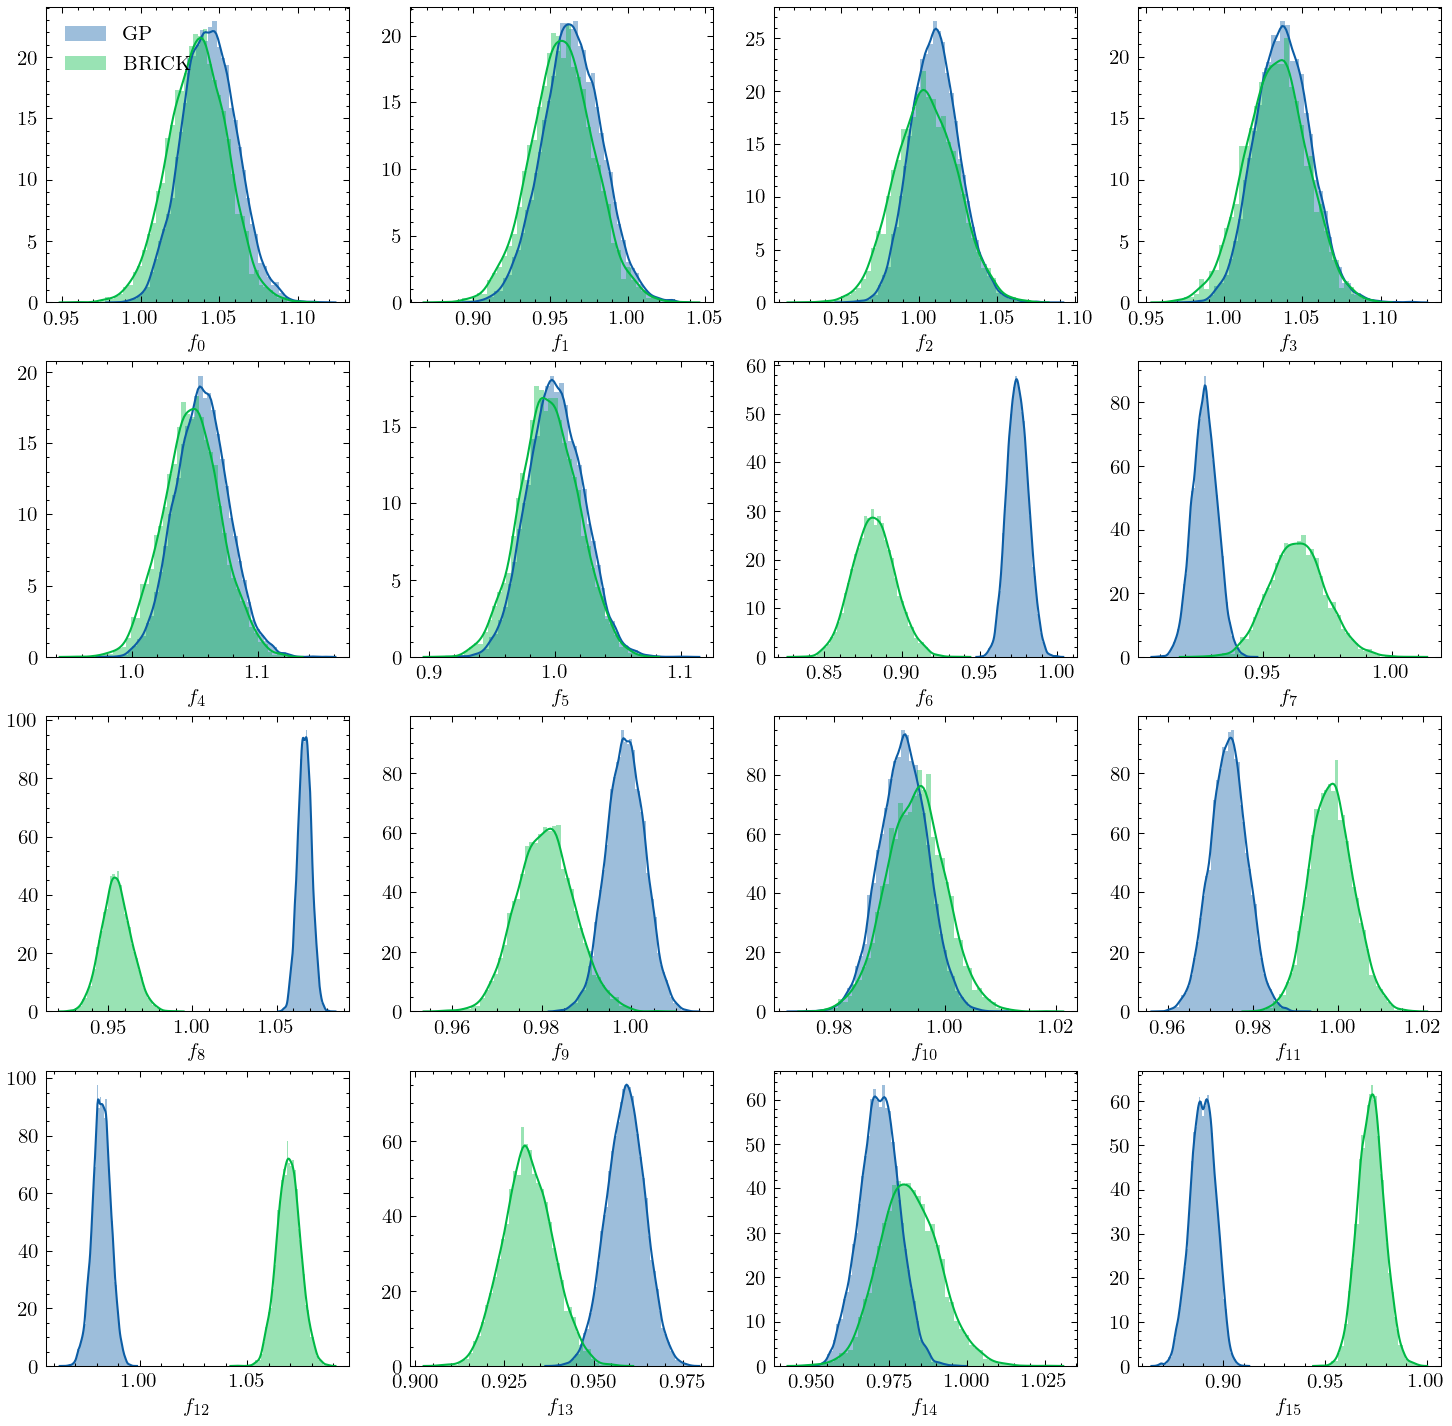

In [40]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = 16 + i*4 + j
        sns.distplot(1/chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel('$f_{%d}$' % (k-16))
ax[0, 0].legend();

In [89]:
from sklearn.metrics import explained_variance_score

In [90]:
from bayes import Model

In [91]:
mu_gp, sigma_gp = m.gp_predict(theta=theta_star[:16])

In [92]:
f_data = m.normalization_factors(theta_star)

In [93]:
explained_variance_score(mu_star, mu_gp)

0.9997296359595081

In [97]:
flat_chain.shape

(64000, 32)

In [100]:
R2_values = []

for theta in flat_chain[::64, :]:
    R2 = explained_variance_score(
        model.calculate(theta), 
        m.gp_predict(theta[:16])[0]
    )
    print(R2)
    R2_values.append(R2)

0.9990370371644703
0.9989800635520226
0.998959806191088
0.9984739810756977
0.9991606682594976
0.9976854219345441
0.9963327963114362
0.9930153858239266
0.9924769219118487
0.9890638267153935
0.9887967869823747
0.9893126533760376
0.9893126533760376
0.9893126533760376
0.992977132077006
0.997167589987299
0.9978323902941699
0.9978323902941699
0.9987953988255047
0.9990679770703971
0.9990679770703971
0.9986165949675666
0.9984859678412976
0.9990938115914205
0.9984040744209296
0.9992100491427677
0.9992100491427677
0.9992100491427677
0.9994282092052894
0.9990230897123701
0.9993338710200751
0.9986149908999273
0.999033126611189
0.999033126611189
0.9995978384569826
0.9994348841938065
0.9989767835000701
0.9978515137167099
0.9984089411169115
0.9984089411169115
0.9985148196801568
0.9991981540148392
0.9991981540148392
0.9987688784774177
0.9988485458943179
0.9993915321411512
0.999397648040132
0.9994776208311176
0.999456829908957
0.9995219010018694
0.9991339190827048
0.9994037350499344
0.9997663737297336


0.9988977717007956
0.9989731509829146
0.9989651056969473
0.9993728299593648
0.9993315086549962
0.9992322483654894
0.9991592787834266
0.9992201348385902
0.999595203355511
0.9997603350507547
0.9998110480651512
0.9998033273567106
0.9998195853717206
0.9997420022676567
0.9992485785019692
0.9993362089067097
0.9997289500027511
0.999716538553943
0.9998244596698967
0.9998612233022559
0.9997797323885536
0.9997234992508326
0.9993499488513856
0.9997819266369627
0.9997879689757333
0.9998462130323383
0.9992863827649333
0.9992863827649333
0.9994470414120811
0.9994196739989722
0.9991695387840963
0.9992884581139411
0.9987934861123065
0.9994737744336234
0.9995957476829503
0.999746556327164
0.9997329684038924
0.9995371732715214
0.9996816126425415
0.999672232199233
0.9994483766513547
0.9994483766513547
0.9995537700083357
0.9995912052869105
0.9993562811161194
0.9998208359954487
0.9989731645493518
0.9988254722065357
0.9988380881254034
0.999454633368316
0.9996279850972161
0.999762952901753
0.9995695383416648

0.9997800720700425
0.9997800720700425
0.9998456372054727
0.9997549569297843
0.9994677613862488
0.999047367463019
0.9995415808148733
0.9994803203443599
0.9997319228053838
0.9996748171625756
0.999697311990506
0.9994808663467145
0.9994213231163027
0.999513257879241
0.9992260586765529
0.9991146477943356
0.999328235039891
0.9992141171817179
0.9996286308063399
0.9996286308063399
0.9992897319668939
0.9996031273285221
0.9996031273285221
0.9991786155376154
0.9993093372785691
0.9996928240695656
0.9996706274499767
0.9992107945334417
0.998814701179635
0.998784035473722
0.9990636414702484
0.9987638230845446
0.9993490262636383
0.9993490262636383
0.9993941416324549
0.9994047933111577
0.999390925328427
0.9990758329994168
0.9993876905299901
0.9992160452512961
0.9993127658121637
0.9992046599118635
0.9992424511049023
0.9996581570207875
0.9998188529466673
0.9998035377069102
0.9998266072313747
0.999718593515907
0.9994568296018507
0.999705923130339
0.9995294426302535
0.9996983959363653
0.9998214305829528
0.

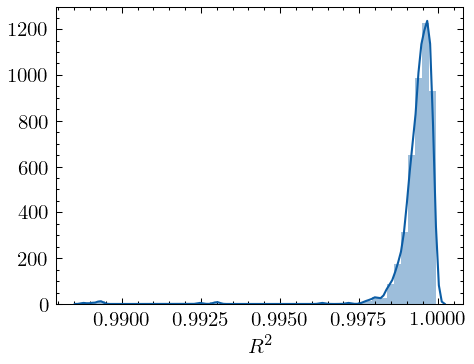

In [103]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

sns.distplot(R2_values, ax=ax)
ax.set_xlabel('$R^2$');